In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import re
from pathlib import Path
import pickle as pkl
import numpy as np
import pandas as pd
from tqdm.autonotebook import trange, tqdm
import matplotlib.pyplot as plt
from torchvision import transforms as T
from core.utils.plot_utils import saveallforms
from core.utils.dataset_utils import ImagePathDataset_pure
from neuro_data_analysis.neural_data_utils import get_all_masks
from neuro_data_analysis.neural_data_lib import load_img_resp_pairs, load_neural_data, get_expstr
from lpips import LPIPS
# from ultralytics import YOLO
# model_new = YOLO("yolov8x.pt")
tabdir = Path(r"E:\OneDrive - Harvard University\Manuscript_BigGAN\Stats_tables")
meta_df = pd.read_csv(tabdir / "meta_activation_stats.csv", index_col=0)

C:\Users\ponce\AppData\Local\Temp\ipykernel_46020\1883882491.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange, tqdm


In [3]:
_, BFEStats = load_neural_data()

In [4]:
for Expi in trange(1, 190+1):
    if BFEStats[Expi-1]["evol"] is None:
        continue
    # expdir = saveroot / f"Both_Exp{Expi}"
    # expdir.mkdir(exist_ok=True)
    imgfps_col0, resp_vec0, bsl_vec0, gen_vec0 = \
        load_img_resp_pairs(BFEStats, Expi, "Evol", thread=0, output_fmt="vec")
    imgfps_col1, resp_vec1, bsl_vec1, gen_vec1 = \
        load_img_resp_pairs(BFEStats, Expi, "Evol", thread=1, output_fmt="vec")
    raise NotImplementedError
    # results_dfs0, yolo_stats_df0 = yolo_process(imgfps_col0, batch_size=100, size=256,
    #                                 savename=f"Exp{Expi:03d}_thread0", sumdir=sumdir)
    # results_dfs1, yolo_stats_df1 = yolo_process(imgfps_col1, batch_size=100, size=256,
    #                                 savename=f"Exp{Expi:03d}_thread1", sumdir=sumdir)

  1%|          | 2/190 [00:00<00:30,  6.09it/s]


NotImplementedError: 

In [18]:
from lpips import LPIPS
lpips_model = LPIPS(net="squeeze")
# lpips_model.forward(gen_vec0, resp_vec0)
device = "cuda" if torch.cuda.is_available() else "cpu"
lpips_model.to(device).eval()
lpips_model.requires_grad_(False)

Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]
Loading model from: c:\Users\ponce\.conda\envs\torch\lib\site-packages\lpips\weights\v0.1\squeeze.pth


c:\Users\ponce\.conda\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ponce\.conda\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


LPIPS(
  (scaling_layer): ScalingLayer()
  (net): squeezenet(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU(inplace=True)
    )
    (slice2): Sequential(
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_s

In [7]:
evol_FC_ds = ImagePathDataset_pure(imgfps_col0, transform=T.ToTensor(), img_dim=(256, 256))
evol_BG_ds = ImagePathDataset_pure(imgfps_col1, transform=T.ToTensor(), img_dim=(256, 256))

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


In [9]:
evol_FC_ds[gen_vec0 == 1]

torch.Size([30, 3, 256, 256])

In [23]:
distmat_col = []
distmat_stats_col = []
max_block = min(gen_vec0.max(), gen_vec1.max())
for block_i in range(1, max_block):
    FC_img_block = evol_FC_ds[gen_vec0 == block_i].to(device)
    BG_img_block = evol_BG_ds[gen_vec1 == block_i].to(device)
    FC_img_next_block = evol_FC_ds[gen_vec0 == block_i+1].to(device)
    BG_img_next_block = evol_BG_ds[gen_vec1 == block_i+1].to(device)
    distmat_FCBG = lpips_model.forward_distmat(FC_img_block, BG_img_block, normalize=True).cpu()
    distmat_FCBG.view(distmat_FCBG.shape[:2])

    distmat_FC_cur2next = lpips_model.forward_distmat(FC_img_block, FC_img_next_block, normalize=True).cpu()
    distmat_FC_cur2next.view(distmat_FC_cur2next.shape[:2])

    distmat_BG_cur2next = lpips_model.forward_distmat(BG_img_block, BG_img_next_block, normalize=True).cpu()
    distmat_BG_cur2next.view(distmat_BG_cur2next.shape[:2])
    
    distmat_FC_curwithin = lpips_model.forward_distmat(FC_img_block, normalize=True).cpu()
    distmat_FC_curwithin.view(distmat_FC_curwithin.shape[:2])
    
    distmat_BG_curwithin = lpips_model.forward_distmat(BG_img_block, normalize=True).cpu()
    distmat_BG_curwithin.view(distmat_BG_curwithin.shape[:2])
    distmat_col.append({"block": block_i,
                        "FC_cur2next": distmat_FC_cur2next, 
                        "BG_cur2next": distmat_BG_cur2next,
                        "FC_curwithin": distmat_FC_curwithin,
                        "BG_curwithin": distmat_BG_curwithin, 
                        "FCBG": distmat_FCBG, })
    
    # print mean and std of distmat_FC_cur2next and distmat_BG_cur2next and distmat_FCBG
    print(f"block {block_i}")
    print("mean and std of distmat_FC_cur2next", distmat_FC_cur2next.mean(), distmat_FC_cur2next.std())
    print("mean and std of distmat_BG_cur2next", distmat_BG_cur2next.mean(), distmat_BG_cur2next.std())
    print("mean and std of distmat_FCBG", distmat_FCBG.mean(), distmat_FCBG.std())
    print("mean and std of distmat_FC_curwithin", distmat_FC_curwithin.mean(), distmat_FC_curwithin.std())
    print("mean and std of distmat_BG_curwithin", distmat_BG_curwithin.mean(), distmat_BG_curwithin.std())


block 1
mean and std of distmat_FC_cur2next tensor(0.4719) tensor(0.0417)
mean and std of distmat_BG_cur2next tensor(0.4991) tensor(0.0632)
mean and std of distmat_FCBG tensor(0.6620) tensor(0.0450)
mean and std of distmat_FC_curwithin tensor(0.4698) tensor(0.0957)
mean and std of distmat_BG_curwithin tensor(0.4841) tensor(0.1155)
block 2
mean and std of distmat_FC_cur2next tensor(0.4483) tensor(0.0368)
mean and std of distmat_BG_cur2next tensor(0.4927) tensor(0.0679)
mean and std of distmat_FCBG tensor(0.6358) tensor(0.0394)
mean and std of distmat_FC_curwithin tensor(0.4415) tensor(0.0810)
mean and std of distmat_BG_curwithin tensor(0.4714) tensor(0.1126)
block 3
mean and std of distmat_FC_cur2next tensor(0.4256) tensor(0.0339)
mean and std of distmat_BG_cur2next tensor(0.4761) tensor(0.0811)
mean and std of distmat_FCBG tensor(0.6375) tensor(0.0438)
mean and std of distmat_FC_curwithin tensor(0.4251) tensor(0.0756)
mean and std of distmat_BG_curwithin tensor(0.4611) tensor(0.1207)
b

In [25]:
import seaborn as sns

In [29]:
distmat_stats_df

,block,distmat_type,mean,std
0,1,FC_cur2next,tensor(0.4719),tensor(0.0417)
1,1,BG_cur2next,tensor(0.4991),tensor(0.0632)
2,1,FCBG,tensor(0.6620),tensor(0.0450)
3,1,FC_curwithin,tensor(0.4698),tensor(0.0957)
4,1,BG_curwithin,tensor(0.4841),tensor(0.1155)
...,...,...,...,...
230,47,FC_cur2next,tensor(0.2494),tensor(0.0230)
231,47,BG_cur2next,tensor(0.3855),tensor(0.1115)
232,47,FCBG,tensor(0.7824),tensor(0.0724)
233,47,FC_curwithin,tensor(0.2500),tensor(0.0474)


In [32]:
# this is easier for sns to plot
distmat_flatten_col = []
for distmat_dict in distmat_col:
    for key in ["FC_cur2next", "BG_cur2next", "FCBG", "FC_curwithin", "BG_curwithin"]:
        distvec = distmat_dict[key].flatten().tolist()
        distmat_flatten_col.append(pd.DataFrame({"block": distmat_dict["block"],
                                                 "distmat_type": key,
                                                 "distmat": distvec}))
distmat_flatten_df = pd.concat(distmat_flatten_col)

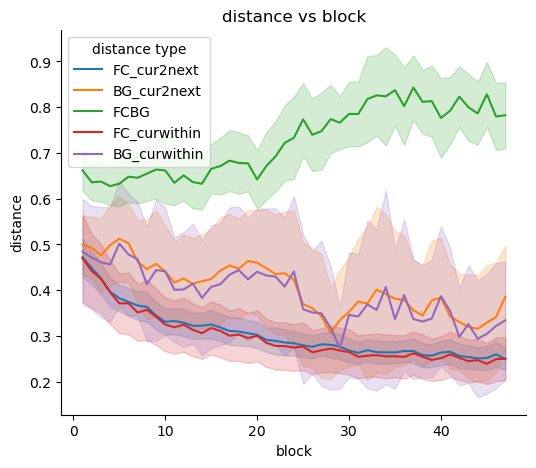

In [41]:
plt.figure(figsize=[6, 5])
sns.lineplot(data=distmat_flatten_df, x="block", y="distmat", hue="distmat_type", errorbar="sd", estimator="mean", n_boot=0) # errorbar=("ci", "std"), estimator="mean", n_boot=0
plt.xlabel("block")
plt.ylabel("distance")
plt.title("distance vs block")
# rename the legend
plt.legend(title="distance type", )#labels=["FC cur-next", None,"BG cur-next", None,"FC vs BG", None,"FC cur within", None,"BG cur within", None,])
plt.show()

ValueError: `errorbar` must be a callable, string, or (string, number) tuple

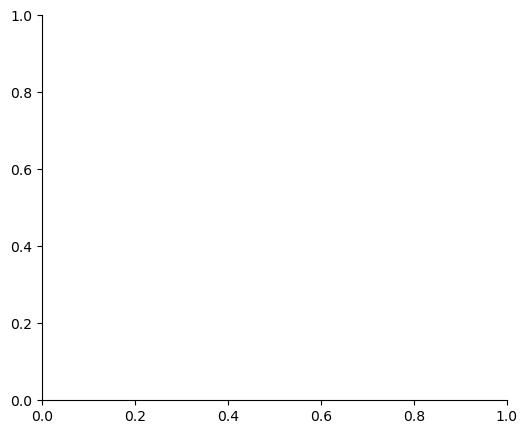

In [31]:
distmat_stats_col = []
for distmat_dict in distmat_col:
    for key in ["FC_cur2next", "BG_cur2next", "FCBG", "FC_curwithin", "BG_curwithin"]:
        distmat_stats_col.append({
            "block": distmat_dict["block"],
            "distmat_type": key,
            "mean": distmat_dict[key].mean().item(),
            "std": distmat_dict[key].std().item(),
        })
    
distmat_stats_df = pd.DataFrame(distmat_stats_col)
# plot the mean and std of distmat_stats_df
plt.figure(figsize=[6, 5])
sns.lineplot(data=distmat_stats_df, x="block", y="mean", hue="distmat_type", errorbar=distmat_stats_df["std"]) # errorbar=("ci", "std"), estimator="mean", n_boot=0
plt.xlabel("block")
plt.ylabel("distance")
plt.title("distance vs block")
plt.show()


### Mass produce

In [50]:
def squeeze_distmat(distmat):
    return distmat.view(distmat.shape[:2])


def compute_distmat_stats(distmat_col):
    distmat_stats_col = []
    for distmat_dict in distmat_col:
        for key in ["FC_cur2next", "BG_cur2next", "FCBG", "FC_curwithin", "BG_curwithin"]:
            distmat_stats_col.append({
                "block": distmat_dict["block"],
                "distmat_type": key,
                "mean": distmat_dict[key].mean().item(),
                "std": distmat_dict[key].std().item(),
            })
        
    distmat_stats_df = pd.DataFrame(distmat_stats_col)
    return distmat_stats_df


def compute_distmat_flatten(distmat_col):
    distmat_flatten_col = []
    for distmat_dict in distmat_col:
        for key in ["FC_cur2next", "BG_cur2next", "FCBG", "FC_curwithin", "BG_curwithin"]:
            distvec = distmat_dict[key].flatten().tolist()
            distmat_flatten_col.append(pd.DataFrame({"block": distmat_dict["block"],
                                                     "dist_type": key,
                                                     "dist": distvec}))
    distmat_flatten_df = pd.concat(distmat_flatten_col)
    return distmat_flatten_df


def plot_distmat_stats(distmat_flatten_df):
    figh = plt.figure(figsize=[6, 5])
    sns.lineplot(data=distmat_flatten_df, x="block", y="dist", hue="dist_type", errorbar="sd", estimator="mean", n_boot=0) # errorbar=("ci", "std"), estimator="mean", n_boot=0
    plt.xlabel("block")
    plt.ylabel("distance")
    plt.title("distance vs block")
    return figh


In [45]:
ephysFN = BFEStats[Expi-1].meta.ephysFN

In [52]:
from tqdm.auto import trange

In [53]:
verbose = False
saveroot = Path(r"E:\OneDrive - Harvard University\Manuscript_BigGAN\Figures\Evol_ImgDist_curve")
# plt.switch_backend('module://backend_interagg')
# plt.switch_backend('Agg')
for Expi in trange(1, 190+1):
    if BFEStats[Expi-1]["evol"] is None:
        continue
    expdir = saveroot / f"Both_Exp{Expi}"
    expdir.mkdir(exist_ok=True)
    ephysFN = BFEStats[Expi-1].meta.ephysFN
    expstr = f"Both Exp{Expi:03d} {ephysFN}"
    imgfps_col0, resp_vec0, bsl_vec0, gen_vec0 = \
        load_img_resp_pairs(BFEStats, Expi, "Evol", thread=0, output_fmt="vec")
    imgfps_col1, resp_vec1, bsl_vec1, gen_vec1 = \
        load_img_resp_pairs(BFEStats, Expi, "Evol", thread=1, output_fmt="vec")
    evol_FC_ds = ImagePathDataset_pure(imgfps_col0, transform=T.ToTensor(), img_dim=(256, 256))
    evol_BG_ds = ImagePathDataset_pure(imgfps_col1, transform=T.ToTensor(), img_dim=(256, 256))
    distmat_col = []
    max_block = min(gen_vec0.max(), gen_vec1.max())
    for block_i in trange(1, max_block):
        FC_img_block = evol_FC_ds[gen_vec0 == block_i].to(device)
        BG_img_block = evol_BG_ds[gen_vec1 == block_i].to(device)
        FC_img_next_block = evol_FC_ds[gen_vec0 == block_i+1].to(device)
        BG_img_next_block = evol_BG_ds[gen_vec1 == block_i+1].to(device)
        distmat_FCBG = lpips_model.forward_distmat(FC_img_block, BG_img_block, normalize=True).cpu()
        distmat_FCBG = squeeze_distmat(distmat_FCBG)

        distmat_FC_cur2next = lpips_model.forward_distmat(FC_img_block, FC_img_next_block, normalize=True).cpu()
        distmat_FC_cur2next = squeeze_distmat(distmat_FC_cur2next)

        distmat_BG_cur2next = lpips_model.forward_distmat(BG_img_block, BG_img_next_block, normalize=True).cpu()
        distmat_BG_cur2next = squeeze_distmat(distmat_BG_cur2next)
        
        distmat_FC_curwithin = lpips_model.forward_distmat(FC_img_block, normalize=True).cpu()
        distmat_FC_curwithin = squeeze_distmat(distmat_FC_curwithin)
        
        distmat_BG_curwithin = lpips_model.forward_distmat(BG_img_block, normalize=True).cpu()
        distmat_BG_curwithin = squeeze_distmat(distmat_BG_curwithin)
        distmat_col.append({"block": block_i,
                            "FC_cur2next": distmat_FC_cur2next, 
                            "BG_cur2next": distmat_BG_cur2next,
                            "FC_curwithin": distmat_FC_curwithin,
                            "BG_curwithin": distmat_BG_curwithin, 
                            "FCBG": distmat_FCBG, })
        
        # print mean and std of distmat_FC_cur2next and distmat_BG_cur2next and distmat_FCBG
        if verbose:
            print(f"block {block_i}")
            print("mean and std of distmat_FC_cur2next", distmat_FC_cur2next.mean(), distmat_FC_cur2next.std())
            print("mean and std of distmat_BG_cur2next", distmat_BG_cur2next.mean(), distmat_BG_cur2next.std())
            print("mean and std of distmat_FCBG", distmat_FCBG.mean(), distmat_FCBG.std())
            print("mean and std of distmat_FC_curwithin", distmat_FC_curwithin.mean(), distmat_FC_curwithin.std())
            print("mean and std of distmat_BG_curwithin", distmat_BG_curwithin.mean(), distmat_BG_curwithin.std())
            
    pkl.dump(distmat_col, open(expdir / "block_distmat_col.pkl", "wb"))
    distmat_stats_df = compute_distmat_stats(distmat_col)
    distmat_flatten_df = compute_distmat_flatten(distmat_col)
    distmat_stats_df.to_csv(expdir / f"block_distmat_stats.csv")
    distmat_flatten_df.to_csv(expdir / f"block_distmat_flatten.csv")
    figh = plot_distmat_stats(distmat_flatten_df)
    figh.gca().set_title(f"{expstr} \n block vs img distance (LPIPS-squeeze)")
    saveallforms(str(expdir), f"{expstr}_block_vs_img_dist", figh)
    plt.close("all")

  0%|          | 0/190 [00:00<?, ?it/s]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


  2%|▏         | 3/190 [01:01<1:03:43, 20.45s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


  2%|▏         | 4/190 [01:44<1:25:37, 27.62s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


  3%|▎         | 5/190 [02:43<1:56:02, 37.63s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


  3%|▎         | 6/190 [03:53<2:25:52, 47.57s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


  4%|▎         | 7/190 [04:45<2:29:37, 49.05s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


  4%|▍         | 8/190 [05:35<2:29:24, 49.25s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


  5%|▍         | 9/190 [06:20<2:24:41, 47.96s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


  5%|▌         | 10/190 [07:07<2:23:04, 47.69s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


  6%|▋         | 12/190 [08:07<1:57:33, 39.63s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


  7%|▋         | 13/190 [08:47<1:57:10, 39.72s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


  7%|▋         | 14/190 [09:44<2:09:43, 44.22s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


  8%|▊         | 15/190 [10:41<2:18:39, 47.54s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


  8%|▊         | 16/190 [11:36<2:24:07, 49.70s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


  9%|▉         | 17/190 [12:22<2:20:33, 48.75s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


  9%|▉         | 18/190 [13:16<2:23:33, 50.08s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 10%|█         | 19/190 [13:55<2:14:00, 47.02s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 11%|█         | 20/190 [14:35<2:07:05, 44.85s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 11%|█         | 21/190 [15:32<2:16:44, 48.55s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 12%|█▏        | 22/190 [16:31<2:24:13, 51.51s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 12%|█▏        | 23/190 [17:37<2:35:55, 56.02s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 13%|█▎        | 24/190 [18:26<2:28:37, 53.72s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 13%|█▎        | 25/190 [19:19<2:27:21, 53.59s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 14%|█▎        | 26/190 [20:05<2:20:05, 51.25s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 14%|█▍        | 27/190 [20:42<2:08:12, 47.19s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 15%|█▍        | 28/190 [21:32<2:09:20, 47.90s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 15%|█▌        | 29/190 [22:22<2:10:22, 48.59s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 16%|█▌        | 30/190 [23:31<2:26:01, 54.76s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 16%|█▋        | 31/190 [24:49<2:43:28, 61.69s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 17%|█▋        | 32/190 [25:40<2:33:41, 58.36s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 17%|█▋        | 33/190 [26:23<2:20:44, 53.79s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 18%|█▊        | 34/190 [26:58<2:05:38, 48.32s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 18%|█▊        | 35/190 [27:38<1:58:21, 45.82s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 19%|█▉        | 36/190 [28:13<1:49:16, 42.58s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 19%|█▉        | 37/190 [28:58<1:50:07, 43.19s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 20%|██        | 38/190 [29:32<1:42:37, 40.51s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 21%|██        | 39/190 [30:11<1:40:15, 39.84s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 21%|██        | 40/190 [30:46<1:35:55, 38.37s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 22%|██▏       | 41/190 [31:51<1:55:50, 46.65s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 22%|██▏       | 42/190 [32:18<1:39:54, 40.50s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 23%|██▎       | 43/190 [32:59<1:40:03, 40.84s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 23%|██▎       | 44/190 [33:29<1:31:04, 37.43s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 24%|██▎       | 45/190 [34:05<1:29:34, 37.06s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 24%|██▍       | 46/190 [34:21<1:13:31, 30.64s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 25%|██▍       | 47/190 [34:49<1:11:18, 29.92s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 25%|██▌       | 48/190 [35:32<1:19:56, 33.78s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 26%|██▌       | 49/190 [36:13<1:24:48, 36.09s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 26%|██▋       | 50/190 [36:31<1:11:08, 30.49s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 27%|██▋       | 51/190 [37:00<1:10:15, 30.33s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 27%|██▋       | 52/190 [37:23<1:04:23, 28.00s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 28%|██▊       | 53/190 [38:13<1:19:05, 34.64s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 28%|██▊       | 54/190 [38:52<1:21:27, 35.94s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 29%|██▉       | 55/190 [39:29<1:21:12, 36.10s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 29%|██▉       | 56/190 [39:58<1:15:55, 34.00s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 30%|███       | 57/190 [40:32<1:15:27, 34.04s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 33%|███▎      | 63/190 [41:41<37:51, 17.89s/it]  

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 34%|███▎      | 64/190 [42:59<55:59, 26.66s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 34%|███▍      | 65/190 [44:05<1:09:34, 33.40s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 35%|███▍      | 66/190 [45:19<1:25:48, 41.52s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 35%|███▌      | 67/190 [46:28<1:37:28, 47.55s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 36%|███▌      | 68/190 [46:45<1:21:32, 40.11s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 36%|███▋      | 69/190 [47:51<1:34:26, 46.83s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 37%|███▋      | 70/190 [49:04<1:47:45, 53.88s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 37%|███▋      | 71/190 [50:17<1:57:10, 59.08s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 38%|███▊      | 72/190 [51:26<2:01:38, 61.85s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 38%|███▊      | 73/190 [52:29<2:01:13, 62.17s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 39%|███▉      | 74/190 [53:33<2:01:14, 62.72s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 39%|███▉      | 75/190 [54:55<2:10:49, 68.25s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 40%|████      | 76/190 [56:22<2:20:41, 74.05s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 41%|████      | 77/190 [57:44<2:23:33, 76.22s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 41%|████      | 78/190 [59:15<2:30:33, 80.66s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 42%|████▏     | 79/190 [1:00:46<2:34:47, 83.67s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 42%|████▏     | 80/190 [1:01:56<2:26:02, 79.66s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 46%|████▌     | 87/190 [1:02:12<37:15, 21.71s/it]  

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 46%|████▋     | 88/190 [1:02:21<33:56, 19.96s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 47%|████▋     | 89/190 [1:03:26<45:43, 27.17s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 47%|████▋     | 90/190 [1:04:14<51:38, 30.98s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 48%|████▊     | 91/190 [1:04:46<51:41, 31.33s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 48%|████▊     | 92/190 [1:05:54<1:04:51, 39.71s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 49%|████▉     | 93/190 [1:06:52<1:11:30, 44.23s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 49%|████▉     | 94/190 [1:07:53<1:17:40, 48.55s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 50%|█████     | 95/190 [1:08:29<1:11:32, 45.19s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 51%|█████     | 96/190 [1:09:45<1:24:22, 53.86s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 52%|█████▏    | 98/190 [1:10:29<1:00:44, 39.61s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 52%|█████▏    | 99/190 [1:11:23<1:05:16, 43.03s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 53%|█████▎    | 100/190 [1:11:51<59:04, 39.38s/it] 

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 53%|█████▎    | 101/190 [1:12:44<1:03:44, 42.97s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 54%|█████▎    | 102/190 [1:13:22<1:01:04, 41.64s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 54%|█████▍    | 103/190 [1:14:08<1:02:14, 42.93s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 55%|█████▍    | 104/190 [1:14:51<1:01:29, 42.90s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 55%|█████▌    | 105/190 [1:15:35<1:00:58, 43.04s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 56%|█████▌    | 106/190 [1:16:15<59:03, 42.18s/it]  

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 56%|█████▋    | 107/190 [1:16:57<58:22, 42.20s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 57%|█████▋    | 109/190 [1:17:51<47:26, 35.15s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 58%|█████▊    | 110/190 [1:18:48<54:01, 40.52s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 58%|█████▊    | 111/190 [1:19:41<57:55, 44.00s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 59%|█████▉    | 112/190 [1:20:16<53:45, 41.35s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 59%|█████▉    | 113/190 [1:21:04<55:26, 43.21s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 60%|██████    | 114/190 [1:22:03<1:00:27, 47.74s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 61%|██████    | 115/190 [1:22:25<50:31, 40.42s/it]  

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 61%|██████    | 116/190 [1:23:07<50:29, 40.94s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 62%|██████▏   | 117/190 [1:23:50<50:32, 41.54s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 62%|██████▏   | 118/190 [1:24:45<54:35, 45.49s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 63%|██████▎   | 119/190 [1:25:05<44:36, 37.69s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 63%|██████▎   | 120/190 [1:25:49<46:13, 39.63s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 64%|██████▎   | 121/190 [1:26:33<47:17, 41.12s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 64%|██████▍   | 122/190 [1:27:21<48:43, 42.99s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 65%|██████▍   | 123/190 [1:28:07<49:13, 44.08s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 65%|██████▌   | 124/190 [1:28:52<48:36, 44.18s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 66%|██████▌   | 125/190 [1:29:40<49:02, 45.26s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 66%|██████▋   | 126/190 [1:30:25<48:29, 45.47s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 67%|██████▋   | 127/190 [1:30:58<43:33, 41.48s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 67%|██████▋   | 128/190 [1:31:31<40:12, 38.92s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 68%|██████▊   | 129/190 [1:32:18<42:15, 41.56s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 68%|██████▊   | 130/190 [1:32:59<41:10, 41.17s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 69%|██████▉   | 131/190 [1:33:43<41:34, 42.28s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 69%|██████▉   | 132/190 [1:34:23<40:04, 41.46s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 70%|███████   | 133/190 [1:34:59<37:44, 39.72s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 71%|███████   | 134/190 [1:35:58<42:29, 45.52s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 71%|███████   | 135/190 [1:36:44<42:01, 45.85s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 72%|███████▏  | 136/190 [1:37:20<38:31, 42.80s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 72%|███████▏  | 137/190 [1:38:02<37:36, 42.57s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 73%|███████▎  | 138/190 [1:38:47<37:37, 43.42s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 73%|███████▎  | 139/190 [1:39:22<34:35, 40.70s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 74%|███████▎  | 140/190 [1:39:59<33:06, 39.73s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 74%|███████▍  | 141/190 [1:40:32<30:45, 37.67s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 75%|███████▍  | 142/190 [1:41:14<31:09, 38.95s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 75%|███████▌  | 143/190 [1:41:53<30:31, 38.97s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 76%|███████▌  | 144/190 [1:42:34<30:25, 39.69s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 76%|███████▋  | 145/190 [1:43:19<30:49, 41.10s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 77%|███████▋  | 146/190 [1:43:47<27:20, 37.30s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 77%|███████▋  | 147/190 [1:44:24<26:36, 37.12s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 78%|███████▊  | 148/190 [1:45:16<29:09, 41.65s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 78%|███████▊  | 149/190 [1:46:21<33:18, 48.75s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 79%|███████▉  | 150/190 [1:47:35<37:28, 56.21s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 79%|███████▉  | 151/190 [1:48:20<34:21, 52.86s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 80%|████████  | 152/190 [1:49:15<33:53, 53.51s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 81%|████████  | 153/190 [1:50:01<31:31, 51.11s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 82%|████████▏ | 155/190 [1:50:39<21:16, 36.47s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 82%|████████▏ | 156/190 [1:51:25<21:52, 38.61s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 83%|████████▎ | 157/190 [1:52:38<26:18, 47.82s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 84%|████████▎ | 159/190 [1:54:06<23:51, 46.17s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 84%|████████▍ | 160/190 [1:55:36<28:11, 56.39s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 85%|████████▍ | 161/190 [1:56:52<29:38, 61.33s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 85%|████████▌ | 162/190 [1:57:08<22:57, 49.20s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 86%|████████▌ | 163/190 [1:57:43<20:27, 45.44s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 86%|████████▋ | 164/190 [1:58:45<21:45, 50.21s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 87%|████████▋ | 165/190 [1:59:30<20:13, 48.54s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 87%|████████▋ | 166/190 [1:59:47<15:48, 39.51s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 88%|████████▊ | 167/190 [2:00:40<16:35, 43.29s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 88%|████████▊ | 168/190 [2:01:29<16:29, 44.98s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 89%|████████▉ | 169/190 [2:02:25<16:56, 48.43s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 89%|████████▉ | 170/190 [2:03:14<16:08, 48.42s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 90%|█████████ | 171/190 [2:04:12<16:16, 51.41s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 91%|█████████ | 172/190 [2:05:02<15:17, 50.95s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 91%|█████████ | 173/190 [2:05:50<14:10, 50.02s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 92%|█████████▏| 174/190 [2:06:47<13:54, 52.13s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 92%|█████████▏| 175/190 [2:07:37<12:52, 51.50s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 93%|█████████▎| 176/190 [2:08:20<11:25, 48.99s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 93%|█████████▎| 177/190 [2:09:11<10:46, 49.71s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 94%|█████████▎| 178/190 [2:10:01<09:54, 49.54s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 94%|█████████▍| 179/190 [2:10:44<08:44, 47.69s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 95%|█████████▍| 180/190 [2:11:29<07:49, 46.91s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 95%|█████████▌| 181/190 [2:12:04<06:30, 43.44s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 97%|█████████▋| 184/190 [2:13:49<03:52, 38.68s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 97%|█████████▋| 185/190 [2:15:13<04:00, 48.17s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 98%|█████████▊| 186/190 [2:16:37<03:45, 56.42s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 98%|█████████▊| 187/190 [2:17:26<02:43, 54.59s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 99%|█████████▉| 188/190 [2:18:11<01:44, 52.13s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


 99%|█████████▉| 189/190 [2:19:10<00:54, 54.11s/it]

The (256, 256) setting is overwritten by the size in custom transform
The (256, 256) setting is overwritten by the size in custom transform


100%|██████████| 190/190 [2:19:54<00:00, 44.18s/it]


In [49]:
str(expdir)

'E:\\OneDrive - Harvard University\\Manuscript_BigGAN\\Figures\\Evol_ImgDist_curve\\Both_Exp3'

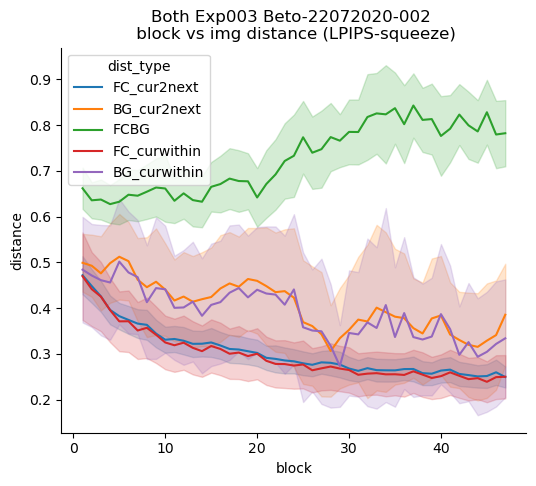

In [48]:
figh

### Post processing


In [ ]:
# maybe get rid of the lower triangle, just vectorize the upper triangle, get rid of the diagonal. for the within block


In [56]:
for Expi in trange(1, 190+1):
    if BFEStats[Expi-1]["evol"] is None:
        continue
    print(Expi)
    break

  1%|          | 2/190 [00:00<00:00, 1998.24it/s]

3


100%|██████████| 190/190 [00:07<00:00, 26.12it/s]


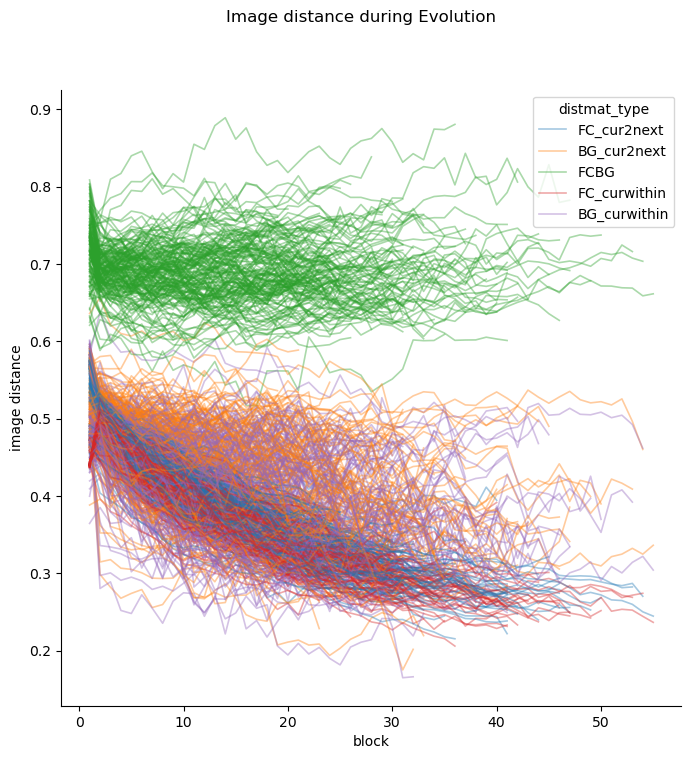

In [61]:
# go through the experiments and crowd source the data
plt.figure(figsize=[8, 8])
for Expi in trange(1, 190+1):
    if BFEStats[Expi-1]["evol"] is None:
        continue
    expdir = saveroot / f"Both_Exp{Expi}"
    dist_stats_df = pd.read_csv(expdir / f"block_distmat_stats.csv", index_col=0) 
    sns.lineplot(data=dist_stats_df, x="block", y="mean", hue="distmat_type", lw=1.2, alpha=0.4, legend=False if Expi != 3 else True)
    # distmat_flatten_df = pd.read_csv(expdir / f"block_distmat_flatten.csv", index_col=0)
    # distmat_flatten_df = distmat_flatten_df[distmat_flatten_df.dist_type.isin(["FC_curwithin", "BG_curwithin"])]
    # distmat_flatten_df.to_csv(expdir / f"block_distmat_flatten_within.csv")
    # plt.title(f"Exp{Expi:03d} {BFEStats[Expi-1].meta.ephysFN}")
plt.ylabel("image distance")
plt.xlabel("block")
plt.suptitle("Image distance during Evolution")
plt.show()

In [62]:
# go through the experiments and crowd source the data
dist_flatten_syn_df = []
for Expi in trange(1, 190+1):
    if BFEStats[Expi-1]["evol"] is None:
        continue
    expdir = saveroot / f"Both_Exp{Expi}"
    dist_flatten_df = pd.read_csv(expdir / f"block_distmat_flatten.csv", index_col=0)
    dist_flatten_df["Expi"] = Expi
    dist_flatten_syn_df.append(dist_flatten_df)
dist_flatten_syn_df = pd.concat(dist_flatten_syn_df)
plt.figure(figsize=[8, 8])
sns.lineplot(data=dist_flatten_syn_df, x="block", y="dist", hue="dist_type", lw=1.2, alpha=0.4, legend=True, errorbar="sd", estimator="mean", n_boot=0)
plt.ylabel("image distance")
plt.xlabel("block")
plt.suptitle("Image distance during Evolution")
plt.show()

100%|██████████| 190/190 [00:14<00:00, 13.09it/s]


KeyboardInterrupt: 

<Figure size 800x800 with 0 Axes>

In [63]:
plt.figure(figsize=[8, 8])
sns.lineplot(data=dist_flatten_syn_df, x="block", y="dist", hue="dist_type", lw=1.2, alpha=0.4, legend=True, errorbar="sd", estimator="mean", n_boot=0)
plt.ylabel("image distance")
plt.xlabel("block")
plt.suptitle("Image distance during Evolution")
plt.show()

In [ ]:
saveroot = Path(r"E:\Network_Data_Sync\BigGAN_Evol_yolo")
sumdir = (saveroot / "yolo_v5_summary")
sumdir.mkdir(exist_ok=True)

figdir = saveroot / "figsummary"
figdir.mkdir(exist_ok=True)
#%%
def yolo_process(imgpathlist, batch_size=100, size=256, savename=None, sumdir=sumdir):
    """Process images with yolo model and return results in a list of dataframes"""
    results_dfs = []
    for i in trange(0, len(imgpathlist), batch_size):
        results = yolomodel(imgpathlist[i:i+batch_size], size=size)
        results_dfs.extend(results.pandas().xyxy)
        # yolo_results[i] = results

    yolo_stats = {}
    for i, single_df in tqdm(enumerate(results_dfs)):
        yolo_stats[i] = {"confidence": single_df.confidence.max(),
                        "class": single_df["class"][single_df.confidence.argmax()] if len(single_df) > 0 else None,
                        "n_objs": len(single_df),
                        "img_path": imgpathlist[i]}
    yolo_stats_df = pd.DataFrame(yolo_stats).T
    if savename is not None:
        yolo_stats_df.to_csv(sumdir / f"{savename}_yolo_stats.csv")
        pkl.dump(results_dfs, open(sumdir / f"{savename}_dfs.pkl", "wb"))
        print(f"Saved to {sumdir / f'{savename}_dfs.pkl'}")
        print(f"Saved to {sumdir / f'{savename}_yolo_stats.csv'}")
    print("Fraction of images with objects", (yolo_stats_df.n_objs > 0).mean())
    print("confidence", yolo_stats_df.confidence.mean(), "confidence with 0 filled",
          yolo_stats_df.confidence.fillna(0).mean())
    print("most common class", yolo_stats_df["class"].value_counts().index[0])
    print("n_objs", yolo_stats_df.n_objs.mean(), )
    return results_dfs, yolo_stats_df


#%%
# Model
yolomodel = torch.hub.load('ultralytics/yolov5', 'yolov5x', pretrained=True)
# plt.switch_backend('module://backend_interagg')
for Expi in trange(1, 190+1):
    if BFEStats[Expi-1]["evol"] is None:
        continue
    expdir = saveroot / f"Both_Exp{Expi}"
    expdir.mkdir(exist_ok=True)
    imgfps_col0, resp_vec0, bsl_vec0, gen_vec0 = \
        load_img_resp_pairs(BFEStats, Expi, "Evol", thread=0, output_fmt="vec")
    imgfps_col1, resp_vec1, bsl_vec1, gen_vec1 = \
        load_img_resp_pairs(BFEStats, Expi, "Evol", thread=1, output_fmt="vec")
    results_dfs0, yolo_stats_df0 = yolo_process(imgfps_col0, batch_size=100, size=256,
                                    savename=f"Exp{Expi:03d}_thread0", sumdir=sumdir)
    results_dfs1, yolo_stats_df1 = yolo_process(imgfps_col1, batch_size=100, size=256,
                                    savename=f"Exp{Expi:03d}_thread1", sumdir=sumdir)


#%%
def sweet_cat_dfs(sumdir, csv_pattern):
    all_df_col = []
    for Expi in trange(1, 190 + 1):
        if BFEStats[Expi - 1]["evol"] is None:
            continue

        df0 = pd.read_csv(sumdir / (csv_pattern % (Expi, 0)), index_col=0)
        df1 = pd.read_csv(sumdir / (csv_pattern % (Expi, 1)), index_col=0)
        df0["thread"] = 0
        df1["thread"] = 1
        df0["Expi"] = Expi
        df1["Expi"] = Expi
        all_df_col.append(df0)
        all_df_col.append(df1)

    all_df = pd.concat(all_df_col)
    all_df["img_name"] = all_df.img_path.apply(lambda x: x.split("\\")[-1])
    # use re to match different part of the string "block001_thread000_gen_gen000_000009.bmp"
    all_df["block"] = all_df.img_name.apply(lambda x: int(re.findall(r"block(\d+)", x)[0]))
    all_df["imgid"] = all_df.img_name.apply(lambda x: int(re.findall(r"gen\d+_(\d+)", x)[0]))
    all_df["confidence_fill0"] = all_df.confidence.fillna(0)
    all_df["included"] = True
    for Expi in meta_df.index:
        part_df0 = all_df[(all_df.Expi == Expi) & (all_df.thread == 0)]
        part_df1 = all_df[(all_df.Expi == Expi) & (all_df.thread == 1)]
        maxblock = max(part_df0.block.max(), part_df1.block.max())
        if (part_df0.block == maxblock).sum() < 10 or (part_df1.block == maxblock).sum() < 10:
            print(f"Expi {Expi} last block {maxblock} has less than 10 images")
            last_block_msk = (all_df.Expi == Expi) & (all_df.block == maxblock)
            all_df.loc[last_block_msk, "included"] = False
            print(f"excluded {last_block_msk.sum()} images from analysis")
            continue
    return all_df
#%% Load all the yolo results and combine them into a single dataframe
all_df_col = []
for Expi in trange(1, 190+1):
    if BFEStats[Expi-1]["evol"] is None:
        continue

    df0 = pd.read_csv(sumdir / f"Exp{Expi:03d}_thread0_yolo_stats.csv", index_col=0)
    df1 = pd.read_csv(sumdir / f"Exp{Expi:03d}_thread1_yolo_stats.csv", index_col=0)
    df0["thread"] = 0
    df1["thread"] = 1
    df0["Expi"] = Expi
    df1["Expi"] = Expi
    all_df_col.append(df0)
    all_df_col.append(df1)

all_df = pd.concat(all_df_col)
# split all_df into name
all_df["img_name"] = all_df.img_path.apply(lambda x: x.split("\\")[-1])
# use re to match different part of the string "block001_thread000_gen_gen000_000009.bmp"
all_df["block"] = all_df.img_name.apply(lambda x: int(re.findall(r"block(\d+)", x)[0]))
all_df["imgid"] = all_df.img_name.apply(lambda x: int(re.findall(r"gen\d+_(\d+)", x)[0]))
all_df["confidence_fill0"] = all_df.confidence.fillna(0)
#%%
all_df["included"] = True
for Expi in meta_df.index:
    part_df0 = all_df[(all_df.Expi == Expi) & (all_df.thread == 0)]
    part_df1 = all_df[(all_df.Expi == Expi) & (all_df.thread == 1)]
    maxblock = max(part_df0.block.max(), part_df1.block.max())
    if (part_df0.block == maxblock).sum() < 10 or (part_df1.block == maxblock).sum() < 10:
        print(f"Expi {Expi} last block {maxblock} has less than 10 images")
        last_block_msk = (all_df.Expi == Expi) & (all_df.block == maxblock)
        all_df.loc[last_block_msk, "included"] = False
        print(f"excluded {last_block_msk.sum()} images from analysis")
        continue
    # raise NotImplementedError
    # all_df.loc[all_df.Expi == Expi, "invalid_last_block"]
    # all_df.loc[all_df.Expi == Expi, "lastblock"] = meta_df.loc[Expi, "last_block"]
    # all_df.loc[all_df.Expi==Expi, "visual_area"] = meta_df.loc[Expi, "visual_area"]
    #
#%%
# use the visual area of the corresponding Expi in metadf in all_df
all_df["visual_area"] = all_df.Expi.apply(lambda x: meta_df.loc[x, "visual_area"])
#%%
all_df.to_csv(sumdir / f"Evol_invivo_all_yolo_stats.csv")
all_df.to_csv(tabdir / f"Evol_invivo_all_yolo_stats.csv")

#%%
from core.yolo_lib import yolo_process_objconf, load_batch_imgpaths
sumdir = (saveroot / "yolo_v5_objconf_summary")
sumdir.mkdir(exist_ok=True)
yolomodel = torch.hub.load('ultralytics/yolov5', 'yolov5x', pretrained=True)
for Expi in trange(1, 190+1):
    if BFEStats[Expi-1]["evol"] is None:
        continue
    expdir = saveroot / f"Both_Exp{Expi}"
    expdir.mkdir(exist_ok=True)
    imgfps_col0, resp_vec0, bsl_vec0, gen_vec0 = \
        load_img_resp_pairs(BFEStats, Expi, "Evol", thread=0, output_fmt="vec")
    imgfps_col1, resp_vec1, bsl_vec1, gen_vec1 = \
        load_img_resp_pairs(BFEStats, Expi, "Evol", thread=1, output_fmt="vec")
    results_dfs0, yolo_stats_df0 = yolo_process_objconf(yolomodel, imgfps_col0, batch_size=100,
                        size=256, savename=f"Exp{Expi:03d}_thread0", sumdir=sumdir)
    results_dfs1, yolo_stats_df1 = yolo_process_objconf(yolomodel, imgfps_col1, batch_size=100,
                        size=256, savename=f"Exp{Expi:03d}_thread1", sumdir=sumdir)

#%%
all_df = sweet_cat_dfs(sumdir, f'Exp%03d_thread%d_yolo_objconf_stats.csv')
all_df["visual_area"] = all_df.Expi.apply(lambda x: meta_df.loc[x, "visual_area"])
all_df.to_csv(sumdir / f"Evol_invivo_all_yolo_objconf_stats.csv")
all_df.to_csv(tabdir / f"Evol_invivo_all_yolo_objconf_stats.csv")
#%%
Amsk, Bmsk, V1msk, V4msk, ITmsk, length_msk, spc_msk, \
    sucsmsk, bsl_unstable_msk, bsl_stable_msk, validmsk = get_all_masks(meta_df)
bothsucmsk = (meta_df.p_maxinit_0 < 0.05) & (meta_df.p_maxinit_1 < 0.05)
#%%
plt.figure(figsize=[12, 8])
plt.scatter(all_df.block, all_df.confidence, s=1, alpha=0.5)
plt.xlabel("block")
plt.ylabel("confidence")
plt.title("confidence vs block")
# plt.savefig(sumdir / "confidence_vs_block.png")
plt.show()
#%%
mean_conf0 = all_df[all_df.thread == 0].groupby(["block"]).confidence_fill0.mean()
mean_conf1 = all_df[all_df.thread == 1].groupby(["block"]).confidence_fill0.mean()
sem_conf0 = all_df[all_df.thread == 0].groupby(["block"]).confidence_fill0.sem()
sem_conf1 = all_df[all_df.thread == 1].groupby(["block"]).confidence_fill0.sem()
#%%
plt.figure(figsize=[12, 8])
plt.errorbar(mean_conf0.index, mean_conf0, yerr=sem_conf0, label="thread0")
plt.errorbar(mean_conf1.index, mean_conf1, yerr=sem_conf1, label="thread1")
plt.xlabel("block")
plt.ylabel("confidence")
plt.title("confidence vs block")
plt.legend()
# plt.savefig(sumdir / "confidence_vs_block.png")
plt.show()
#%%
all_df[all_df.thread==0].groupby(["block"]).confidence_fill0.mean().plot()
all_df[all_df.thread==1].groupby(["block"]).confidence_fill0.mean().plot()
plt.xlabel("block")
plt.ylabel("confidence")
plt.title("confidence vs block")
# plt.savefig(sumdir / "confidence_vs_block.png")
plt.show()
#%%
import seaborn as sns
# mask some Expi
sel_Expi = meta_df[validmsk & ITmsk & bothsucmsk].index
#%%
plt.figure(figsize=[5, 5])
sns.lineplot(data=all_df[all_df.Expi.isin(sel_Expi)],
             x="block", y="confidence_fill0", hue="thread",
             errorbar="se", estimator="mean", n_boot=0)
plt.xlabel("block")
plt.ylabel("confidence")
plt.title("confidence vs block")
# plt.savefig(sumdir / "confidence_vs_block.png")
plt.show()
#%%
plt.figure(figsize=[5, 5])
for areamsk in [V1msk, V4msk, ITmsk]:
    sel_Expi = meta_df[validmsk & areamsk].index
    sns.lineplot(data=all_df[all_df.Expi.isin(sel_Expi)],
                 x="block", y="confidence_fill0", hue="thread",
                 errorbar="se", estimator="mean", n_boot=0)
plt.xlabel("block")
plt.ylabel("confidence")
plt.title("confidence vs block")
# plt.savefig(sumdir / "confidence_vs_block.png")
plt.show()
#%%
plt.figure(figsize=[5, 5])
sns.lineplot(x="block", y="confidence_fill0", data=all_df[all_df.Expi == 69], hue="thread",
             errorbar="se", estimator="mean", n_boot=0)
plt.xlabel("block")
plt.ylabel("confidence")
plt.title("confidence vs block")
# plt.savefig(sumdir / "confidence_vs_block.png")
plt.show()
#%%
msk_sfx = "validbothsuc"
sel_Expi = meta_df[validmsk & bothsucmsk].index
plt.figure(figsize=[5, 5])
sns.lineplot(data=all_df[all_df["included"] & all_df.Expi.isin(sel_Expi)],
             x="block", y="confidence_fill0", hue="visual_area", style="thread",
             errorbar="se", estimator="mean", n_boot=0)
plt.xlabel("block")
plt.ylabel("confidence")
plt.title("confidence vs block [Valid & Both Success]")
saveallforms(str(figdir), f"confid_vs_block_traj_{msk_sfx}")
plt.show()
#%%
msk_sfx = "allvalid"
sel_Expi = meta_df[validmsk].index
plt.figure(figsize=[5, 5])
sns.lineplot(data=all_df[all_df["included"] & all_df.Expi.isin(sel_Expi)],
             x="block", y="confidence_fill0", hue="visual_area", style="thread",
             errorbar="se", estimator="mean", n_boot=0)
plt.xlabel("block")
plt.ylabel("confidence")
plt.title("confidence vs block [Valid]")
saveallforms(str(figdir), f"confid_vs_block_traj_{msk_sfx}")
plt.show()
#%%
def plot_confidence_curve(all_df, meta_df, title_mask_str,
                          all_msk=None, sel_Expi=None, msk_sfx="",
                          hue_var="visual_area", style_var="thread"):
    if all_msk is None:
        all_msk = all_df["included"]
    if sel_Expi is None:
        sel_Expi = meta_df.index
    fig = plt.figure(figsize=[5, 5])
    sns.lineplot(data=all_df[all_msk & all_df.Expi.isin(sel_Expi)],
                 x="block", y="confidence_fill0", hue=hue_var, style=style_var,
                 errorbar="se", estimator="mean", n_boot=0)
    plt.xlabel("block")
    plt.ylabel("confidence")
    plt.title(f"confidence vs block [{title_mask_str}]")
    saveallforms(str(figdir), f"confid_vs_block_traj_{msk_sfx}")
    plt.show()
    return fig
#%%


plot_confidence_curve(all_df, meta_df, "Valid", msk_sfx="allvalid",
                sel_Expi=meta_df[validmsk].index, )
plot_confidence_curve(all_df, meta_df, "Valid & Both Success", msk_sfx="validbothsuc",
              sel_Expi=meta_df[bothsucmsk & validmsk].index)
plot_confidence_curve(all_df, meta_df, "Valid & Any Success", msk_sfx="validanysuc",
              sel_Expi=meta_df[sucsmsk & validmsk].index)
plot_confidence_curve(all_df, meta_df, "Valid & None Success", msk_sfx="validnonesuc",
              sel_Expi=meta_df[~sucsmsk & validmsk].index)
#%%
for Expi in meta_df.index:
    expstr = get_expstr(BFEStats, Expi)
    plot_confidence_curve(all_df, meta_df, f"Exp {Expi}\n{expstr}", msk_sfx=f"Exp{Expi:03d}",
                          sel_Expi=[Expi], hue_var="thread", )


